In [6]:

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER

from online_algos import OLMAR

import pandas as pd
import matplotlib.pyplot as plt

PLOT_DATES_TEST_START = '2021-02-09'
PLOT_DATES_TEST_END = '2024-01-01'

ensemble_results_file = 'result.csv'

# PLOT_DATES_TEST_START = '2022-01-03'
# PLOT_DATES_TEST_END = '2022-12-30'

# ensemble_results_file = 'result2022.csv'


value_to_remove = "DOW"
# # Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]


# test = [
# "AXP",
#     "AMGN",
#     "AAPL",
#     "BA",
#     "CAT"]


df = YahooDownloader(start_date = PLOT_DATES_TEST_START,
                     end_date = PLOT_DATES_TEST_END,
                     ticker_list = DOW_30_TICKER).fetch_data()


print(df.head())

# Count rows with any null values
null_rows_count = df.isnull().any(axis=1).sum()

print(f"Number of rows containing null values: {null_rows_count}")


print("Check for no-nulls")
print(df.notnull().all().all())

assert df.notnull().all().all()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (21112, 8)
         date        open        high         low       close    volume   tic  \
0  2021-02-09  136.619995  137.880005  135.850006  133.343338  76774200  AAPL   
1  2021-02-09  237.279999  237.669998  234.789993  210.427582   1996500  AMGN   
2  2021-02-09  127.650002  127.660004  126.199997  120.796021   2175000   AXP   
3  2021-02-09  210.600006  216.729996  208.899994  215.119995  13615700    BA   
4  2021-02-09  197.539993  198.660004  194.889999  183.065567   2331600   CAT   

   day  
0    1  
1    1  
2    1  
3    1  
4    1  
Number of rows containing null values: 0
Check for no-nulls
True


date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
tic        object
day         int32
dtype: object
             date        open        high         low       close    volume  \
0      2021-02-09  136.619995  137.880005  135.850006  133.343338  76774200   
1      2021-02-09  237.279999  237.669998  234.789993  210.427582   1996500   
2      2021-02-09  127.650002  127.660004  126.199997  120.796021   2175000   
3      2021-02-09  210.600006  216.729996  208.899994  215.119995  13615700   
4      2021-02-09  197.539993  198.660004  194.889999  183.065567   2331600   
...           ...         ...         ...         ...         ...       ...   
21107  2023-12-29  525.979980  528.239990  523.919983  520.342346   2080100   
21108  2023-12-29  260.570007  261.459991  259.670013  258.866302   4074600   
21109  2023-12-29   37.380001   37.759998   37.320000   35.344772  16205200   
21110  2023-12-29   26.440001   26.629999   25.75000

<Axes: xlabel='date'>

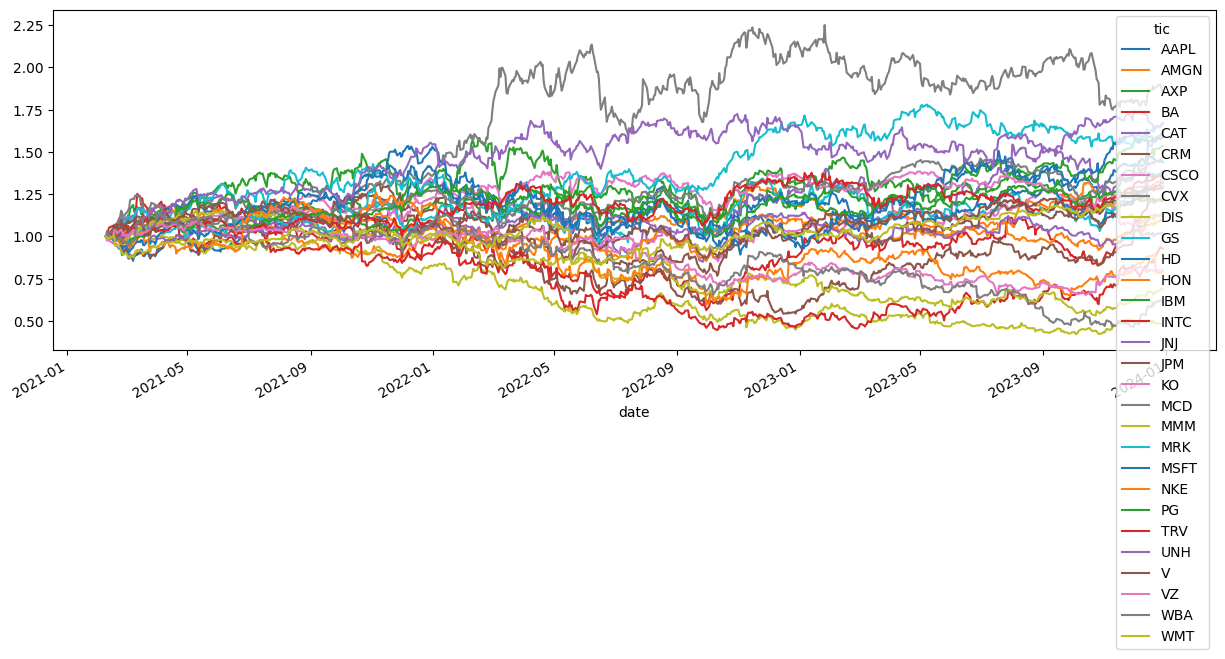

In [7]:
df = pd.DataFrame(df)

print(df.dtypes)
print(df)

# Pivot the DataFrame
pivot_df = df.pivot(index='date', columns='tic', values='close')

print(pivot_df)

pivot_df.index = pd.to_datetime(pivot_df.index)

(pivot_df / pivot_df.iloc[0,:]).plot()


Final Portfolio:
Shares: AAPL     234.0
AMGN       0.0
AXP      518.0
BA       676.0
CAT       19.0
CRM      267.0
CSCO       0.0
CVX      141.0
DIS      564.0
GS        38.0
HD        60.0
HON      117.0
IBM      284.0
INTC    4859.0
JNJ      285.0
JPM      365.0
KO       213.0
MCD      230.0
MMM        5.0
MRK      261.0
MSFT     135.0
NKE        0.0
PG         0.0
TRV      178.0
UNH        0.0
V         83.0
VZ      1628.0
WBA        0.0
WMT        0.0
dtype: float64
Total of each: AAPL     44881.707733
AMGN              0.0
AXP      95893.904266
BA      176206.162476
CAT       5529.051025
CRM      69947.856262
CSCO              0.0
CVX      20368.598465
DIS       50689.70224
GS       14383.456909
HD       20402.757568
HON      24141.335037
IBM      45180.978271
INTC    240937.903492
JNJ      43647.496033
JPM      60638.493271
KO         12272.4715
MCD      66984.278259
MMM        444.061775
MRK      27919.923019
MSFT     50489.456177
NKE               0.0
PG                0.0
TRV

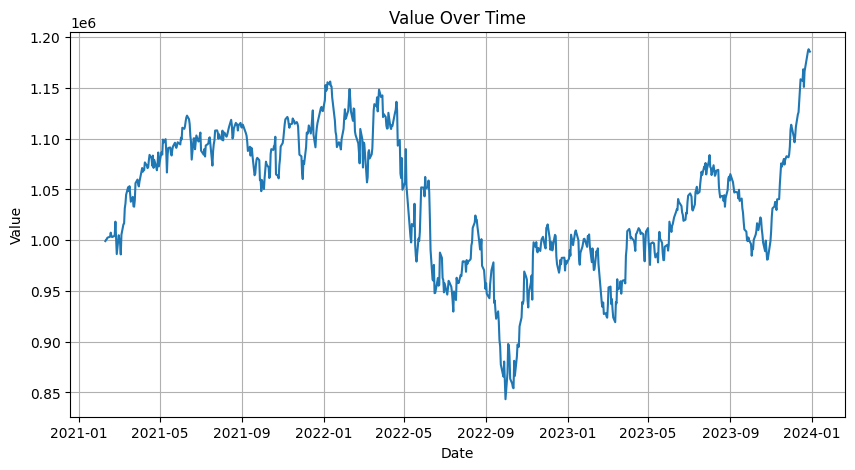

In [8]:
import numpy as np
import pandas as pd

transaction_fees=[]

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def rebalance_portfolio_olmar(cash, shares, prices, window=10, eps=10):
    # Calculate Moving Averages
    sma = calculate_sma(prices, window)
    
    # Calculate price deviation
    deviation = prices.iloc[-1] / sma.iloc[-1] - 1
    
    # Update target weights based on OLMAR algorithm
    excess_return = eps - deviation.mean()
    weights = np.maximum(0, deviation * excess_return)
    weights = weights / weights.sum()  # Normalize the weights

    if(weights.isnull().values.any()):
        # Default to uniform weights if no weights are calculated yet
        weights = (np.ones(len(prices.iloc[-1]))) / (len(prices.iloc[-1]))

    remaining_cash = cash
    
    # Available amount for purchases of each stock, must factor in the transaction cost
    current_wealth = (np.sum(prices.iloc[-1] * shares) + cash) / (1 + transaction_cost)

    target_values = weights * current_wealth
    target_shares = target_values // (prices.iloc[-1])
    
    shares_to_change = target_shares - shares

    sell_shares = np.where(shares_to_change < 0, -shares_to_change, 0)
    buy_shares = np.where(shares_to_change > 0, shares_to_change, 0)
    sale_amount = (np.sum(sell_shares * prices.iloc[-1]) + np.sum(buy_shares * prices.iloc[-1]))
    transaction_fee = (np.sum(sell_shares * prices.iloc[-1]) + np.sum(buy_shares * prices.iloc[-1])) * transaction_cost

    # Test a shrinkage factor
    pending_transaction = cash + np.sum(sell_shares * prices.iloc[-1]) - np.sum(buy_shares * prices.iloc[-1]) - transaction_fee

    # We are about to go negative on cash, need to use the shrink factor
    if (pending_transaction < 0):
        shrink_factor = (np.sum(prices.iloc[-1] * shares) + cash) / ((1 + transaction_cost) * sale_amount )
        shares_to_change = np.floor(shares_to_change * shrink_factor)

    # Readjusted to the shrink factor if needed
    sell_shares = np.where(shares_to_change < 0, -shares_to_change, 0)
    buy_shares = np.where(shares_to_change > 0, shares_to_change, 0)
    sale_amount = (np.sum(sell_shares * prices.iloc[-1]) + np.sum(buy_shares * prices.iloc[-1]))
    transaction_fee = (np.sum(sell_shares * prices.iloc[-1]) + np.sum(buy_shares * prices.iloc[-1])) * transaction_cost
    
    cash += np.sum(sell_shares * prices.iloc[-1])
    cash -= np.sum(buy_shares * prices.iloc[-1])

    shares = shares + shares_to_change
    remaining_cash = cash - transaction_fee

    transaction_fees.append(transaction_fee)

    assert remaining_cash >= 0, "Cash went negative"
    
    return shares, remaining_cash, weights


transaction_cost = 0.001

new_column_names = ['Date'] + [f'{col}' for col in pivot_df.columns]

# Convert to the desired format
X = pivot_df.reset_index()
X.columns = new_column_names

# Initialize to uniform shares
initial_cash = 1000000
initial_shares = np.ones(len(X.columns) - 1) / (len(X.columns) - 1)
net_worth = []

portfolio_shares = initial_shares
portfolio_cash = initial_cash

rebalance_iter = 50
rebalance_i = rebalance_iter

# Rebalance at each step
for idx, row in X.iterrows():
    price_per_share = row[1:].values
    
    # Reset the index as needed
    if (rebalance_i % rebalance_iter == 0):
        portfolio_shares, portfolio_cash, target_weights = rebalance_portfolio_olmar(
        portfolio_cash, 
        portfolio_shares, 
        X.set_index('Date').iloc[:idx+1], 
        window=5, 
        eps=10)

        rebalance_i = 0
    rebalance_i += 1
    
    asset_wealth = np.sum(portfolio_shares * price_per_share)
    net_worth.append(asset_wealth + portfolio_cash)

print("\nFinal Portfolio:")
print(f"Shares: {portfolio_shares}")
print(f"Total of each: {portfolio_shares * price_per_share}")
print(f"Cash: {portfolio_cash:.2f}")
print(f"Transaction fees: {np.sum(np.array(transaction_fees))}")
print(f"Final Net Worth: {net_worth[-1]}")


# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(X['Date'], net_worth)
plt.title('Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Write this out to a csv file, with date and net worth
df = pd.DataFrame(net_worth, columns=['OLMAR_net_worth'])
if len(df) == len(X):
    df['Date'] = X['Date']
    df.set_index('Date', inplace=True)
else:
    raise ValueError("DataFrames do not have the same number of rows.")
df.to_csv('OLMAR_net_worth.csv')

                0
0    9.991499e+05
1    1.000435e+06
2    1.001009e+06
3    1.002472e+06
4    1.003473e+06
..            ...
723  1.170318e+06
724  1.185954e+06
725  1.188189e+06
726  1.186779e+06
727  1.185802e+06

[728 rows x 1 columns]
          Date  OLMAR Net Worth
0   2021-02-09     9.991499e+05
1   2021-02-10     1.000435e+06
2   2021-02-11     1.001009e+06
3   2021-02-12     1.002472e+06
4   2021-02-16     1.003473e+06
..         ...              ...
723 2023-12-22     1.170318e+06
724 2023-12-26     1.185954e+06
725 2023-12-27     1.188189e+06
726 2023-12-28     1.186779e+06
727 2023-12-29     1.185802e+06

[728 rows x 2 columns]
                ensemble           dji
date                                  
2021-04-06  1.000000e+06  1.000000e+06
2021-04-07  9.999256e+05  1.000479e+06
2021-04-08  1.000077e+06  1.002194e+06
2021-04-09  1.003741e+06  1.011079e+06
2021-04-12  1.003101e+06  1.009427e+06
...                  ...           ...
2023-09-28  9.934112e+05  1.007063e+06
2

<Figure size 1500x500 with 0 Axes>

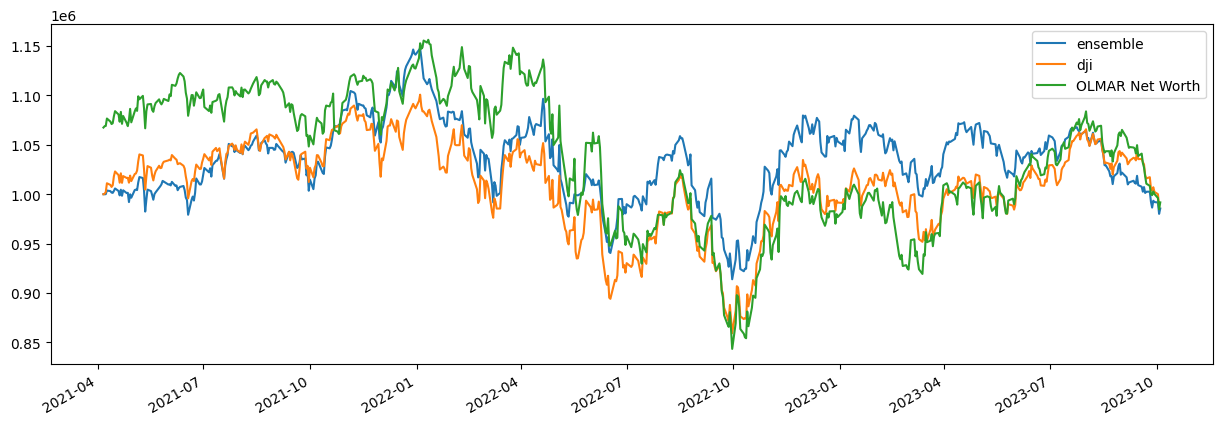

In [9]:
result = pd.DataFrame()

df = pd.DataFrame(net_worth)

print(df)

# Combine the DataFrames side-by-side
combined_df = pd.concat([X.Date, df], axis=1)

combined_df.columns = ["Date", "OLMAR Net Worth"]
print(combined_df)

combined_df.set_index('Date', inplace=True)

# TODO Change result period to use saved file
result = pd.read_csv(ensemble_results_file)

result.set_index('date', inplace=True)

result.index = pd.to_datetime(result.index)

print(result)

# Join DataFrames on date index
merged_df = result.join(combined_df, how='inner')
print(merged_df)


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
merged_df.plot();

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (727, 8)
Annual return          0.065817
Cumulative returns     0.201884
Annual volatility      0.150714
Sharpe ratio           0.498889
Calmar ratio           0.299976
Stability              0.000069
Max drawdown          -0.219408
Omega ratio            1.088298
Sortino ratio          0.711059
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.010215
Daily value at risk   -0.018690
dtype: float64
Baseline Sharpe: -1.1731538958252306
==============Get Backtest Stats===========
Annual return          0.061078
Cumulative returns     0.186811
Annual volatility      0.166319
Sharpe ratio           0.440084
Calmar ratio           0.225637
Stability              0.122285
Max drawdown          -0.270694
Omega ratio            1.078059
Sortino ratio          0.628498
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.026918
Daily value at risk   -0.02066


C:\Users\bencj\AppData\Local\Temp\ipykernel_7300\1934935889.py:25: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  sharpe = timeseries.sharpe_ratio(daily_ret, risk_free= 0.001)
C:\Users\bencj\AppData\Local\Temp\ipykernel_7300\1934935889.py:40: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  sharpe = timeseries.sharpe_ratio(daily_ret, risk_free= 0.001)


Backtest Sharpe: -1.075079807882523
==============Compare to DJIA===========


<Figure size 1500x500 with 0 Axes>

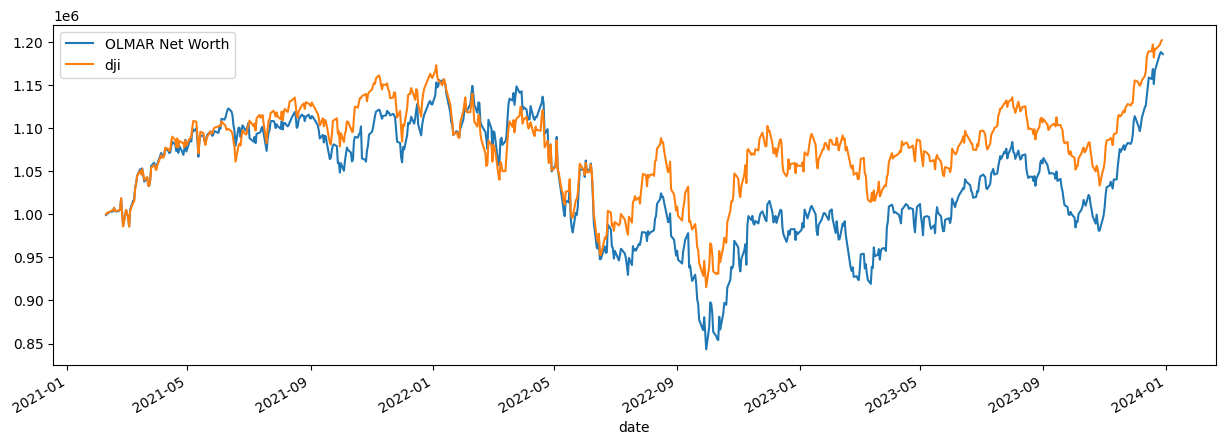

In [10]:
from finrl.plot import backtest_stats,  get_baseline, get_daily_return
from pyfolio import timeseries

first_date = combined_df.index.min()
last_date = combined_df.index.max()


print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = first_date,
        end = last_date)

stats = backtest_stats(df_dji_, value_col_name = 'close')


df_dji = pd.DataFrame()
df_dji['date'] = combined_df.index
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * initial_cash
df_dji = df_dji.set_index(df_dji.columns[0])


daily_ret = get_daily_return(df_dji_, value_col_name = 'close')
# TODO use the correct rf rate
sharpe = timeseries.sharpe_ratio(daily_ret, risk_free= 0.001)
print("Baseline Sharpe:", sharpe)


combined_df = pd.DataFrame({'date': combined_df.index, 'OLMAR Net Worth': combined_df['OLMAR Net Worth']})
combined_df = combined_df.set_index('date')


print("==============Get Backtest Stats===========")
backtest_df = pd.DataFrame({'date': combined_df.index, 'OLMAR Net Worth': combined_df['OLMAR Net Worth']})
stats = backtest_stats(account_value=backtest_df, value_col_name="OLMAR Net Worth")


daily_ret = get_daily_return(backtest_df, value_col_name="OLMAR Net Worth")
# TODO use the correct rf rate
sharpe = timeseries.sharpe_ratio(daily_ret, risk_free= 0.001)
print("Backtest Sharpe:", sharpe)

print("==============Compare to DJIA===========")
result = pd.DataFrame()

result = pd.merge(combined_df, df_dji, left_index=True, right_index=True)
# print("result: ", result)


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();